In [ ]:
!pip install matplotlib scikit-learn

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import sklearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Carga del archivo
df = pd.read_csv('dataset.csv')

# Imprime las primeras filas del archivo
print(df.head())

  text_type                                               text
0      spam  naturally irresistible your corporate identity...
1      spam  the stock trading gunslinger fanny is merrill ...
2      spam  unbelievable new homes made easy im wanting to...
3      spam  4 color printing special request additional in...
4      spam  do not have money get software cds from here s...


text_type
ham     14337
spam     6011
Name: count, dtype: int64


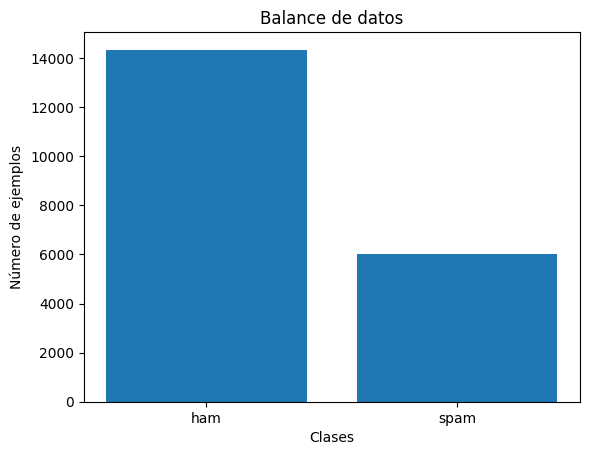

In [ ]:
# Verificamos si el está balanceado
class_counts = df['text_type'].value_counts()
print(class_counts)

# Graficar un gráfico de barras para visualizar el balance de clases
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases')
plt.ylabel('Número de ejemplos')
plt.title('Balance de datos')
plt.show()

Distribución de datos después del balanceo:
text_type
ham     6011
spam    6011
Name: count, dtype: int64


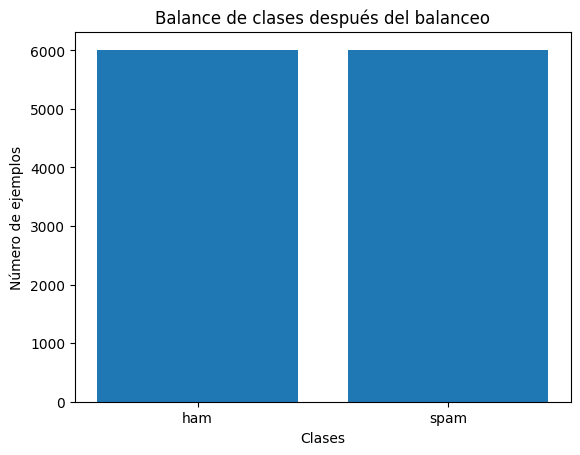

In [ ]:
# Aplicar oversampling de la clase minoritaria
# oversampler = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = oversampler.fit_resample(df.drop('text_type', axis=1), df['text_type'])

# Aplicar undersampling de la clase mayoritaria
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df.drop('text_type', axis=1), df['text_type'])

# Verificar la distribución de clases después del balanceo
df_resampled = pd.DataFrame(X_resampled, columns=df.drop('text_type', axis=1).columns)
df_resampled['text_type'] = y_resampled
class_counts_after = df_resampled['text_type'].value_counts()
print("Distribución de datos después del balanceo:")
print(class_counts_after)

# Graficar un gráfico de barras para visualizar el balance de clases después del balanceo
plt.bar(class_counts_after.index, class_counts_after.values)
plt.xlabel('Clases')
plt.ylabel('Número de ejemplos')
plt.title('Balance de clases después del balanceo')
plt.show()

In [ ]:
# Limpieza de datos: eliminar caracteres especiales
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Eliminar saltos de línea
    text = re.sub(r'\r', '', text)  # Eliminar retornos de carro
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales excepto palabras y espacios
    return text

# Limpieza de datos: convertir textos a minúsculas
def lowercase_text(text):
    return text.lower()

# Dividir textos en palabras o tokens individuales
def tokenize_text(text):
    return text.split()

# Aplicar limpieza y tokenización a la columna de textos en el DataFrame df_resampled
df_resampled['texto_filtrado'] = df_resampled['text'].apply(clean_text)
df_resampled['minusculas'] = df_resampled['texto_filtrado'].apply(lowercase_text)
df_resampled['tokens'] = df_resampled['minusculas'].apply(tokenize_text)

# Verificar los resultados
print("Ejemplos de textos limpios y tokenizados:")
print(df_resampled[['text', 'tokens']].head())

Ejemplos de textos limpios y tokenizados:
                                                text  \
0  url url date 1635465 1635465 1635465t1635465 1...   
1  edith terry scott i spoke briefly with edith t...   
2                             i liked the new mobile   
3  new powermod 97 xls marty absolutely yes we ar...   
4  would me smoking you out help us work through ...   

                                              tokens  
0  [url, url, date, 1635465, 1635465, 1635465t163...  
1  [edith, terry, scott, i, spoke, briefly, with,...  
2                       [i, liked, the, new, mobile]  
3  [new, powermod, 97, xls, marty, absolutely, ye...  
4  [would, me, smoking, you, out, help, us, work,...  


In [ ]:
nltk.download('stopwords')

# Descargar la lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para eliminar stopwords de un texto
def eliminar_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# Aplicar eliminación de stopwords a la columna 'tokens' en el DataFrame df_resampled
df_resampled['tokens_cleaned'] = df_resampled['tokens'].apply(eliminar_stopwords)

# Verificar los resultados
print("DATOS sin stopwords:")
print(df_resampled[['text', 'tokens', 'tokens_cleaned']].head())

DATOS sin stopwords:
                                                text  \
0  url url date 1635465 1635465 1635465t1635465 1...   
1  edith terry scott i spoke briefly with edith t...   
2                             i liked the new mobile   
3  new powermod 97 xls marty absolutely yes we ar...   
4  would me smoking you out help us work through ...   

                                              tokens  \
0  [url, url, date, 1635465, 1635465, 1635465t163...   
1  [edith, terry, scott, i, spoke, briefly, with,...   
2                       [i, liked, the, new, mobile]   
3  [new, powermod, 97, xls, marty, absolutely, ye...   
4  [would, me, smoking, you, out, help, us, work,...   

                                      tokens_cleaned  
0  [url, url, date, 1635465, 1635465, 1635465t163...  
1  [edith, terry, scott, spoke, briefly, edith, t...  
2                               [liked, new, mobile]  
3  [new, powermod, 97, xls, marty, absolutely, ye...  
4  [would, smoking, help, us, 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
  # Creado un objeto de vectorización
  tfidf_vectorizer = TfidfVectorizer()
  X_tfidf = tfidf_vectorizer.fit_transform(df_resampled['texto_filtrado'])

  # Verificar las primeras palabras o tokens (vocabulario)
  print("Vocabulario (TfidfVectorizer):")
  print(tfidf_vectorizer.get_feature_names_out()[:10])

  # Verificar la matriz resultante (representación numérica de los textos)
  print("Matriz de TfidfVectorizer:")
  print(X_tfidf.toarray())

Vocabulario (TfidfVectorizer):
['00' '000' '0000' '000000' '00000000' '000000000003997' '000000000005168'
 '000000000005411' '000000000005413' '000000000007498']
Matriz de TfidfVectorizer:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_resampled['text_type'], test_size=0.2, random_state=42)

# Verificar los tamaños de los conjuntos resultantes
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (9617, 48812)
Tamaño del conjunto de prueba: (2405, 48812)


In [92]:
# Crear una instancia del modelo Logistic Regression
logreg_model = LogisticRegression(class_weight='balanced', random_state=42)

# Entrenar el modelo Logistic Regression con el conjunto de entrenamiento
logreg_model.fit(X_train, y_train)

# Una vez entrenado, puedes usar el modelo para hacer predicciones
y_pred_logreg = logreg_model.predict(X_test)

# Calcular la precisión del modelo
accuracy_logreg = logreg_model.score(X_test, y_test)

# Imprimir la precisión del modelo Logistic Regression
# print("Precisión del modelo Logistic Regression:", accuracy_logreg)

# Calcular métricas de evaluación
print("Métricas de evaluación para Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Calcular la matriz de confusión
conf_matrix_lr = confusion_matrix(y_test, y_pred_logreg)
print("Matriz de confusión para Logistic Regression:")
print(conf_matrix_lr)

Métricas de evaluación para Logistic Regression:
              precision    recall  f1-score   support

         ham       0.91      0.92      0.91      1206
        spam       0.92      0.90      0.91      1199

    accuracy                           0.91      2405
   macro avg       0.91      0.91      0.91      2405
weighted avg       0.91      0.91      0.91      2405

Matriz de confusión para Logistic Regression:
[[1114   92]
 [ 115 1084]]


In [91]:
# Crear una instancia del modelo Support Vector Machine (SVM)
svm_model = SVC(class_weight='balanced', random_state=42)

# Entrenar el modelo SVM con el conjunto de entrenamiento
svm_model.fit(X_train, y_train)

# Una vez entrenado, puedes usar el modelo para hacer predicciones
y_pred_svm = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy_svm = svm_model.score(X_test, y_test)

# Imprimir la precisión del modelo SVM
# print("Precisión del modelo SVM:", accuracy_svm)

# Calcular métricas de evaluación
print("Métricas de evaluación para Logistic Regression:")
print(classification_report(y_test, y_pred_svm))

# Calcular la matriz de confusión
conf_matrix_lr = confusion_matrix(y_test, y_pred_svm)
print("Matriz de confusión para Logistic Regression:")
print(conf_matrix_lr)

Métricas de evaluación para Logistic Regression:
              precision    recall  f1-score   support

         ham       0.93      0.95      0.94      1206
        spam       0.94      0.92      0.93      1199

    accuracy                           0.93      2405
   macro avg       0.93      0.93      0.93      2405
weighted avg       0.93      0.93      0.93      2405

Matriz de confusión para Logistic Regression:
[[1140   66]
 [  92 1107]]


In [90]:
# Crear una instancia del modelo Decision Tree Classifier
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Entrenar el modelo Decision Tree Classifier con el conjunto de entrenamiento
dt_model.fit(X_train, y_train)

# Una vez entrenado, puedes usar el modelo para hacer predicciones
y_pred_dt = dt_model.predict(X_test)

# Calcular la precisión del modelo
accuracy_dt = dt_model.score(X_test, y_test)

# Imprimir la precisión del modelo Decision Tree Classifier
# print("Precisión del modelo Decision Tree Classifier:", accuracy_dt)

# Calcular métricas de evaluación
print("Métricas de evaluación para Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))

# Calcular la matriz de confusión
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Matriz de confusión para Decision Tree Classifier:")
print(conf_matrix_dt)

Métricas de evaluación para Decision Tree Classifier:
              precision    recall  f1-score   support

         ham       0.86      0.88      0.87      1206
        spam       0.88      0.86      0.87      1199

    accuracy                           0.87      2405
   macro avg       0.87      0.87      0.87      2405
weighted avg       0.87      0.87      0.87      2405

Matriz de confusión para Decision Tree Classifier:
[[1059  147]
 [ 168 1031]]


In [89]:
# Crear una instancia del modelo Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Entrenar el modelo Random Forest Classifier con el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Una vez entrenado, puedes usar el modelo para hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy_rf = rf_model.score(X_test, y_test)

# Imprimir la precisión del modelo Random Forest Classifier
# print("Precisión del modelo Random Forest Classifier:", accuracy_rf)

# Calcular métricas de evaluación
print("Métricas de evaluación para Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

# Calcular la matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Matriz de confusión para Random Forest Classifier:")
print(conf_matrix_rf)

Métricas de evaluación para Random Forest Classifier:
              precision    recall  f1-score   support

         ham       0.91      0.96      0.93      1206
        spam       0.96      0.90      0.93      1199

    accuracy                           0.93      2405
   macro avg       0.93      0.93      0.93      2405
weighted avg       0.93      0.93      0.93      2405

Matriz de confusión para Random Forest Classifier:
[[1163   43]
 [ 121 1078]]
